# Board Game Text Analysis

In [12]:
#install.packages("tidytext")
#install.packages("textdata")
#install.packages("RSQLite")
#install.packages("fivethirtyeight")
#install.packages("forcats")
#install.packages("rsample")
#install.packages("rpart.plot")
#install.packages("tidyr")
#install.packages("widyr")
#install.packages("ggrepel") #`geom_label_repel`
#install.packages("gridExtra") #`grid.arrange()` for multi-graphs
#install.packages("knitr") #Create nicely formatted output tables
#install.packages("kableExtra") #Create nicely formatted output tables
#install.packages("formattable") #For the color_tile function
#install.packages("circlize") #Visualizations - chord diagram
#install.packages("memery") #Memes - images with plots
#install.packages("magick") #Memes - images with plots (image_read)
#install.packages("yarrr")  #Pirate plot
#install.packages("radarchart") #Visualizations
#install.packages("igraph") #ngram network diagrams
#install.packages("ggraph") #ngram network diagrams
#install.packages("showtextdb")

library(ggrepel) #`geom_label_repel`
library(gridExtra) #`grid.arrange()` for multi-graphs
library(knitr) #Create nicely formatted output tables
library(kableExtra) #Create nicely formatted output tables
library(formattable) #For the color_tile function
library(circlize) #Visualizations - chord diagram
library(memery) #Memes - images with plots
library(magick) #Memes - images with plots (image_read)
library(yarrr)  #Pirate plot
library(radarchart) #Visualizations
library(igraph) #ngram network diagrams
library(ggraph) #ngram network diagrams
library(tidyr, quietly = TRUE, warn.conflicts = FALSE)
library(widyr, quietly = TRUE, warn.conflicts = FALSE)
library(broom, quietly = TRUE, warn.conflicts = FALSE)
library(forcats, quietly = TRUE, warn.conflicts = FALSE)
library(rpart.plot, quietly = TRUE, warn.conflicts = FALSE)
library(rsample, quietly = TRUE, warn.conflicts = FALSE)
library(tidyr, quietly = TRUE, warn.conflicts = FALSE)
library(fivethirtyeight, quietly = TRUE, warn.conflicts = FALSE)
library(RSQLite, quietly = TRUE, warn.conflicts = FALSE)
library(DBI, quietly = TRUE, warn.conflicts = FALSE)
library(ggplot2, quietly = TRUE, warn.conflicts = FALSE)
library(dplyr, quietly = TRUE, warn.conflicts = FALSE)
library(readr, quietly = TRUE, warn.conflicts = FALSE)
library(tidytext, quietly = TRUE, warn.conflicts = FALSE)
library(textdata, quietly = TRUE, warn.conflicts = FALSE)
library(stringr, quietly = TRUE, warn.conflicts = FALSE)
library(lubridate, quietly = TRUE, warn.conflicts = FALSE)
library(knitr, quietly = TRUE, warn.conflicts = FALSE)
library(hunspell, quietly = TRUE, warn.conflicts = FALSE)
library(rpart, quietly = TRUE, warn.conflicts = FALSE)
options(scipen = 99)


In [34]:
bgames = dbConnect(RSQLite::SQLite(), "database.sqlite")

In [35]:
alltables = dbListTables(bgames)
p1 = dbGetQuery( bgames,'select * from BoardGames' )

p1 <- p1 %>%  filter(game.id !=680)
p1 <- p1 %>% filter(game.id !=63)

[1] 90398    81

In [8]:
my_hunspell_stem <- function(token) {
  stem_token <- hunspell_stem(token)[[1]]
  if (length(stem_token) == 0) return(token) else return(stem_token[1])
}
vec_hunspell_stem <- Vectorize(my_hunspell_stem, "token")


In [17]:
desc_tokens <- p1 %>% 
  mutate(details.description = str_replace_all(details.description, 
                                pattern=regex("(www|https?[^\\s]+)"), 
                                replacement = "")) %>% #rm urls
  mutate(details.description = str_replace_all(details.description,
                                pattern = "[[:digit:]]",
                                replacement = "")) %>% 
  unnest_tokens(tokens, details.description) %>% #tokenize
  mutate(tokens = vec_hunspell_stem(tokens)) %>% 
  filter(!(tokens %in% stop_words$word)) #rm stopwords

In [10]:
write.csv(desc_tokens, file = "desc_tokens.csv")


In [38]:
desc_tokens=read.csv("desc_tokens.csv")


## Sentiment Analysis

In [139]:
afinn_sentiment <- system.file("extdata", "afinn.csv", package = "fivethirtyeight") %>% 
  read_csv()

desc_sentiment <- desc_tokens %>% 
  inner_join(afinn_sentiment, by=c("tokens"="word")) 

p1$game.id=as.numeric(p1$game.id)

desc_comb <- desc_sentiment %>% 
  group_by(game.id) %>% 
  summarise(score = sum(value, na.rm=TRUE)) %>% 
  ungroup() %>% 
  right_join(p1, by="game.id") %>% 
  mutate(score_factor = ifelse(is.na(score), "Missing score", 
                               ifelse(score < 0, "negative", 
                                      ifelse(score == 0, "0", "positive"))))




Parsed with column specification:
cols(
  word = col_character(),
  value = col_double()
)
Warning message:
"Column `tokens`/`word` joining factor and character vector, coercing into character vector"

In [141]:
sentOverTimeGraph <- ggplot(data=filter(desc_comb,!is.na(score) & details.yearpublished>1990 ), aes(x=details.yearpublished, y=score)) +
  geom_col() +
  geom_smooth(method = "loess", se = FALSE) +
  xlab("Date") +
  ylab("Sentiment (afinn)") +
  ggtitle(paste0("Game Description Sentiment"))




In [142]:
polarity_year <- desc_comb %>%
filter(details.yearpublished >= 1990 & !is.na(score)) %>%
  count(score_factor, details.yearpublished) %>%
  spread(score_factor, n, fill = 0) %>%
mutate(percent=positive/(positive+negative))

relative_polarity_over_time <- polarity_year %>%
  ggplot(aes(details.yearpublished, percent)) +
  geom_col() +
  geom_smooth(method = "loess", se = FALSE) +
  xlab("Date") +
  ylab("Sentiment (afinn)") +
  ggtitle(paste0("Game Description Sentiment"))


In [143]:
sentOverRateGraph <- ggplot(data=filter(desc_comb,!is.na(score) & stats.average>5 ), aes(x=score, y=stats.average)) +
  geom_point() +
  ylab("Average BGG Rating") +
  xlab("Sentiment (afinn)") +
  ggtitle("Sentiment Has No Clear Association with Rating")


In [144]:
WantOverSentGraph <- ggplot(data=filter(desc_comb,!is.na(score)), aes(y=stats.wanting, x=score)) +
  geom_point() +
  ylab("Number of Users with Game on Wishlist") +
  xlab("Sentiment (afinn)") +
  geom_smooth()+
  ggtitle("Wishlist Listings Seem to Prefer Descriptions of Middling Valence")


In [98]:
nrc_sentiment <- read.csv("NRC.csv")


desc_nrc <- desc_tokens %>% 
  inner_join(nrc_sentiment, by=c("tokens"="English..en.")) 


desc_comb_nrc <- desc_nrc %>% 
  group_by(game.id) %>% 
  summarise(AngerSum = sum(Anger, na.rm=TRUE),AnticipationSum=sum(Anticipation, na.rm=TRUE),DisgustSum=sum(Disgust, na.rm=TRUE),
           FearSum=sum(Fear, na.rm=TRUE),JoySum=sum(Joy, na.rm=TRUE),SadSum=sum(Sadness, na.rm=TRUE),
           SurpriseSum=sum(Surprise, na.rm=TRUE),TrustSum=sum(Trust, na.rm=TRUE)) %>% 
  ungroup() %>% 
  right_join(p1, by="game.id")


Warning message:
"Column `tokens`/`English..en.` joining factors with different levels, coercing to character vector"

In [114]:
install.packages("reshape2")
library(reshape2)

package 'reshape2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\geeki_000\AppData\Local\Temp\Rtmpu21NIQ\downloaded_packages


Warning message:
"package 'reshape2' was built under R version 3.6.2"
Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths



Observations: 240
Variables: 3
$ details.yearpublished <int> 1990, 1991, 1992, 1993, 1994, 1995, 1996, 199...
$ Emotion               <fct> AngerSum, AngerSum, AngerSum, AngerSum, Anger...
$ Score                 <dbl> 0.1177225, 0.1106862, 0.1177982, 0.1154246, 0...


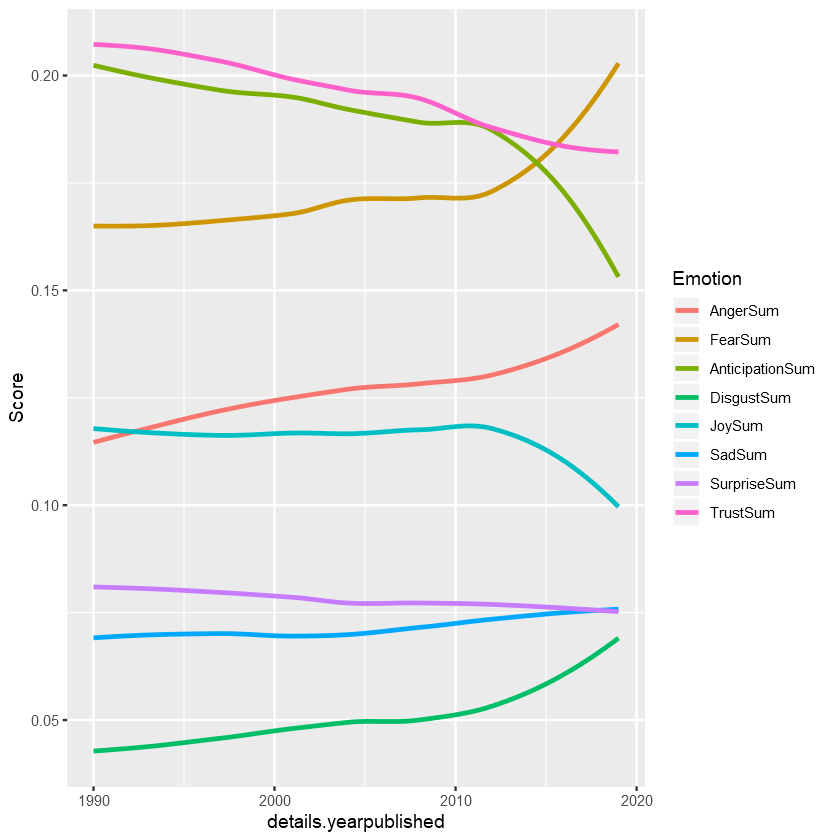

In [118]:
nrc_year <- desc_comb_nrc %>%
filter(details.yearpublished >= 1990 & !is.na(AngerSum)) %>%
group_by(details.yearpublished) %>%
  summarise_at(c("AngerSum","FearSum","AnticipationSum","DisgustSum","JoySum","SadSum","SurpriseSum","TrustSum"),sum) %>%
mutate(total = AngerSum+FearSum+AnticipationSum+DisgustSum+JoySum+SadSum+SurpriseSum+TrustSum) %>%
 mutate_at(c("AngerSum","FearSum","AnticipationSum","DisgustSum","JoySum","SadSum","SurpriseSum","TrustSum"),list(~./total))

nrc_year <- melt(nrc_year,id.vars=c("details.yearpublished"),measure.vars=c("AngerSum","FearSum","AnticipationSum","DisgustSum","JoySum","SadSum","SurpriseSum","TrustSum"),
                variable.name="Emotion",value.name="Score")

glimpse(nrc_year)

ggplot(data=nrc_year, aes(x=details.yearpublished, y=Score, fill=Emotion)) +
#geom_bar(stat="identity", position=position_dodge()) +
  geom_smooth(method = "loess", se = FALSE,aes(color=Emotion)) 


Observations: 516,456
Variables: 4
$ details.yearpublished <int> 1998, 1992, 1993, 1998, 1998, 1997, 1999, 199...
$ Quality               <chr> "negative", "negative", "negative", "negative...
$ Emotion               <fct> AngerSum, AngerSum, AngerSum, AngerSum, Anger...
$ Score                 <int> 2582, 2118, 1898, 2582, 2582, 2006, 2730, 241...


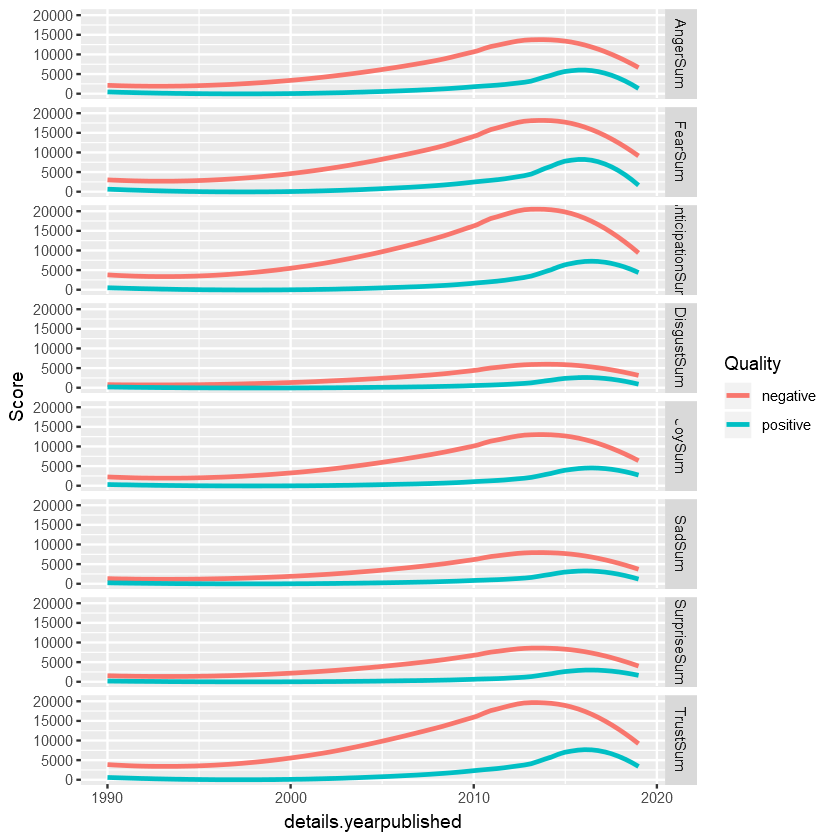

In [138]:
nrc_year_rate <- desc_comb_nrc %>%
filter(details.yearpublished >= 1990) %>%
 mutate(Quality = ifelse(is.na(stats.average), "Missing score", 
                               ifelse(stats.average < 7.5, "negative", 
                                      ifelse(stats.average >= 7.5, "positive","Missing Score")))) %>%
group_by(details.yearpublished,Quality) %>%
  mutate_at(c("AngerSum","FearSum","AnticipationSum","DisgustSum","JoySum","SadSum","SurpriseSum","TrustSum")
            ,sum,na.rm=TRUE) 

nrc_year_rate <- melt(nrc_year_rate,id.vars=c("details.yearpublished","Quality"),measure.vars=c("AngerSum","FearSum","AnticipationSum","DisgustSum","JoySum","SadSum","SurpriseSum","TrustSum"),
                variable.name="Emotion",value.name="Score")

glimpse(nrc_year_rate)

ggplot(data=nrc_year_rate, aes(x=details.yearpublished, y=Score, fill=Quality)) +
#geom_bar(stat="identity", position=position_dodge()) +
  geom_smooth(method = "loess", se = FALSE,aes(color=Quality))  +
facet_grid(rows = vars(Emotion))






## Regression Tree of Words to Average Rating

In [64]:
desc_words <- desc_tokens %>%
    count(details.name,tokens,sort=TRUE)

total_words <- desc_words %>%
    group_by(details.name) %>%
    summarize(total=sum(n))

desc_summ <- left_join(desc_words,total_words)


desc_summ <- desc_summ %>%
    bind_tf_idf(tokens,details.name,n)



Joining, by = "details.name"


In [91]:
desc_cl <- desc_tokens

sparse_words <- desc_cl %>%
    count(details.name,tokens) %>%
    cast_sparse(details.name,tokens,n)
sparse_words = as.data.frame(as.matrix(sparse_words))

ERROR: Error in asMethod(object): Cholmod error 'problem too large' at file ../Core/cholmod_dense.c, line 105


In [ ]:
glimpse(sparse_words)

In [19]:
desc_cl <- desc_tokens

sparse_words <- desc_cl %>%
    count(details.name,tokens) %>%
    cast_sparse(details.name,tokens,n)

sparse_words = as.data.frame(as.matrix(sparse_words))


colnames(sparse_words) = make.names(colnames(sparse_words))

sort_val <- p1 %>%
    arrange(details.name) %>%
    select(stats.average)
dataset=cbind(sparse_words,sort_val)


desc_split <- dataset %>% initial_split()

train_data <- training(desc_split)
test_data <- testing(desc_split)



ERROR: Error in data.frame(..., check.names = FALSE): arguments imply differing number of rows: 4922, 4998


In [ ]:
desc_part=rpart(stats.average~.,data=train_data)

In [ ]:
prp(desc_part)

In [ ]:
test.pred.rtree <- predict(desc_part,test_data)
table(round(test_data$stats.average),round(test.pred.rtree))

RMSE.rtree <- sqrt(mean((round(test_data$stats.average)-round(test.pred.rtree))^2))

sprintf("RMSE is %f", RMSE.rtree) 